In [2]:
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
import numpy as np
from scipy.stats import truncnorm
from sklearn.preprocessing import normalize

## Italy

In [374]:
DB_reg=pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")

In [373]:
POP=pd.read_csv("https://www.istat.it/storage/codici-unita-amministrative/Elenco-comuni-italiani.csv",encoding="windows-1252",sep=";",thousands=".")
POP.rename({"Popolazione legale 2011 (09/10/2011)":"population",'Codice Regione':"codice_regione"},axis=1,inplace=True)
POP_DATA=POP.groupby('codice_regione',as_index=False)['population'].sum()
DB_reg=pd.merge(DB_reg,POP_DATA,on='codice_regione',how='left')

In [377]:
## take last day
DD=DB_reg.loc[DB_reg['data']==DB_reg['data'].max(),:].copy()
## fatality rate
DD['fatality_rate']=DD['deceduti']/DD['totale_casi']
## positivity rate
DD['positivity_rate']=DD['totale_casi']/DD['casi_testati']
## test_capacity

DD['reg_index']=DD['denominazione_regione']
DD.set_index('reg_index',inplace=True)
#DD.sort_values('fatality_rate',ascending=False).round(3);

In [378]:
results=smf.ols('fatality_rate  ~ +positivity_rate  ',data=DD).fit(cov_type='HC2')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fatality_rate   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     29.26
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           3.22e-05
Time:                        13:18:56   Log-Likelihood:                 52.505
No. Observations:                  21   AIC:                            -101.0
Df Residuals:                      19   BIC:                            -98.92
Df Model:                           1                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0548      0.006      8.666      0.000       0.042       0.067
positivity_rate     0.2866      0.053      5.409      0.000       0.183       0.390
==============================================================================
Omnibus:                        8.386   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                5.943
Skew:                          -1.013   Prob(JB):                       0.0512
Kurtosis:                       4.640   Cond. No.                         10.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

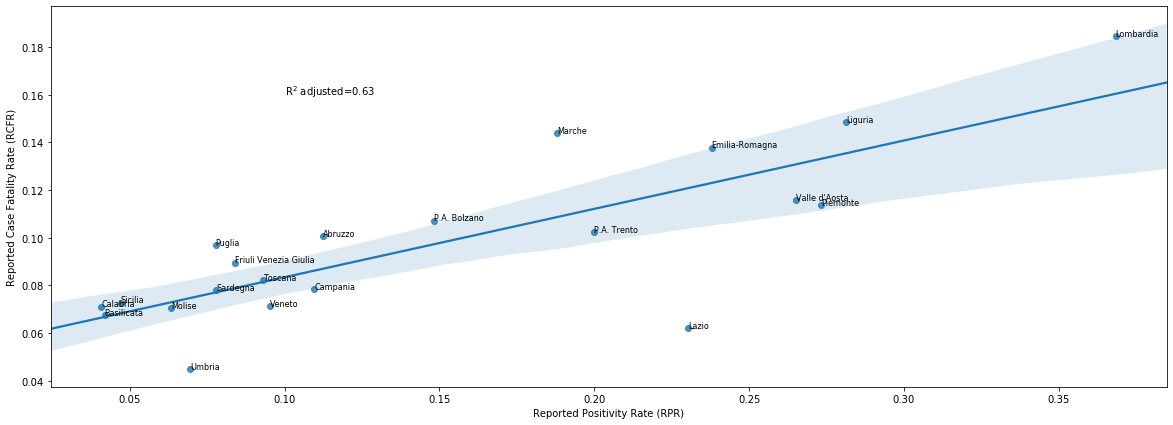

In [385]:
fig,axs=plt.subplots(figsize=(20,7))
#DD=DB_reg.groupby('denominazione_regione',as_index=False)['totale_casi','tamponi','deceduti','ricoverati_con_sintomi','totale_ospedalizzati'].last()

#sns.lineplot(y=results.predict(),x=DD['positivity_rate'],ax=axs)
sns.regplot(y=DD['fatality_rate'],x=DD['positivity_rate'],ax=axs);

for y,x,label in zip(DD['fatality_rate'],DD['positivity_rate'],DD['denominazione_regione']):
    axs.text(x,y,label,fontsize=8)

axs.text(0.10,0.16,"R$^{2}$ adjusted="+str(np.round(results.rsquared_adj,2)))
axs.set_xlabel("Reported Positivity Rate (RPR)")
axs.set_ylabel("Reported Case Fatality Rate (RCFR)");

## WORLD

In [338]:
AA=pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
print("total countries wit non-null values: "+str(AA.loc[AA['total_tests'].isnull()==False,'iso_code'].nunique()))
AA.loc[AA['total_tests'].isnull()==False,'iso_code'].unique()

total countries wit non-null values: 78


array(['ARG', 'AUS', 'AUT', 'BEL', 'BGD', 'BGR', 'BHR', 'BOL', 'CAN',
       'CHE', 'CHL', 'COL', 'CRI', 'CUB', 'CZE', 'DEU', 'DNK', 'ECU',
       'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GBR', 'GHA', 'GRC', 'HKG',
       'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'ISL', 'ISR', 'ITA',
       'JPN', 'KAZ', 'KEN', 'KOR', 'LTU', 'LUX', 'LVA', 'MAR', 'MEX',
       'MMR', 'MYS', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'PAK', 'PAN',
       'PER', 'PHL', 'POL', 'PRT', 'PRY', 'ROU', 'RUS', 'RWA', 'SEN',
       'SGP', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'THA', 'TUN', 'TUR',
       'TWN', 'UGA', 'URY', 'USA', 'VNM', 'ZAF'], dtype=object)

In [339]:
AA_onlycases=AA.loc[AA['tests_units'].isin(['inconsistent units (COVID Tracking Project)',np.nan])==False,:].copy()

In [340]:
CONFIRMED_CASES=pd.read_csv("confirmed_cases_JH.csv",index_col=0)
DEATHS=pd.read_csv("deaths_JH.csv",index_col=0)
codes_iso=pd.read_csv("ISO3_COUNTRYREG.csv",index_col=0)
DF_TEST=pd.read_csv("full-list-total-tests-for-covid-19.csv")

In [341]:
def reshape_data(dataset,var_name):
    ## reshape of the JH dataset
    CC=dataset
    var_calendario=CC.columns[4:]
    var_ids=CC.columns[0:4]
    CC=pd.melt(CC,var_ids,var_calendario,var_name='time',value_name=var_name)
    CC=CC.groupby(['Country/Region','time'],as_index=False)[var_name].sum()
    return CC


list_dataset=[CONFIRMED_CASES,DEATHS]
list_var_name=['confirmed_cases','deaths_cases']
DF=pd.DataFrame()

i=0
for dt,vn in zip(list_dataset,list_var_name):
    if i==0:
        DF=DF.append(reshape_data(dataset=dt,var_name=vn))
    else:
        DF=pd.merge(DF,reshape_data(dataset=dt,var_name=vn),on=['time','Country/Region'],how='left')
    i+=1


In [342]:
DF=pd.merge(DF,codes_iso[['ISO3',"Country/Region"]].drop_duplicates(),on='Country/Region',how='left')

In [343]:
## format time variable

DF_TEST['time']=pd.to_datetime(DF_TEST['Date'])
DF['time']=pd.to_datetime(DF['time'])

## change names
DF_TEST.rename({'Code':'ISO3'},inplace=True,axis=1)
DF_TEST.rename({'Total tests':'tests'},inplace=True,axis=1)

AA_onlycases.rename({'iso_code':'ISO3'},inplace=True,axis=1)
AA_onlycases.rename({'total_tests':'tests'},inplace=True,axis=1)
AA_onlycases['time']=pd.to_datetime(AA_onlycases['date'])

## merge

#DF_ANALYSIS=pd.merge(DF,DF_TEST,on=['time','ISO3'],how='left')

### questo è per usare onlyu cases
DF_ANALYSIS=pd.merge(DF,AA_onlycases,on=['time','ISO3'],how='left')

## ratio variables
DF_ANALYSIS['death_rate']=DF_ANALYSIS['deaths_cases']/DF_ANALYSIS['confirmed_cases']
DF_ANALYSIS['positivity_rate']=DF_ANALYSIS['confirmed_cases']/DF_ANALYSIS['tests']

### drop null values and countries with less than 100 deaths
DF_PLT=DF_ANALYSIS.loc[DF_ANALYSIS['deaths_cases']>=100,:]
DF_PLOT=DF_PLT.dropna().copy()

## take last observation in time order
DFZ=DF_PLOT.sort_values('time',ascending=False).groupby(['ISO3'],as_index=False)['death_rate','positivity_rate','time','confirmed_cases','tests'].first()

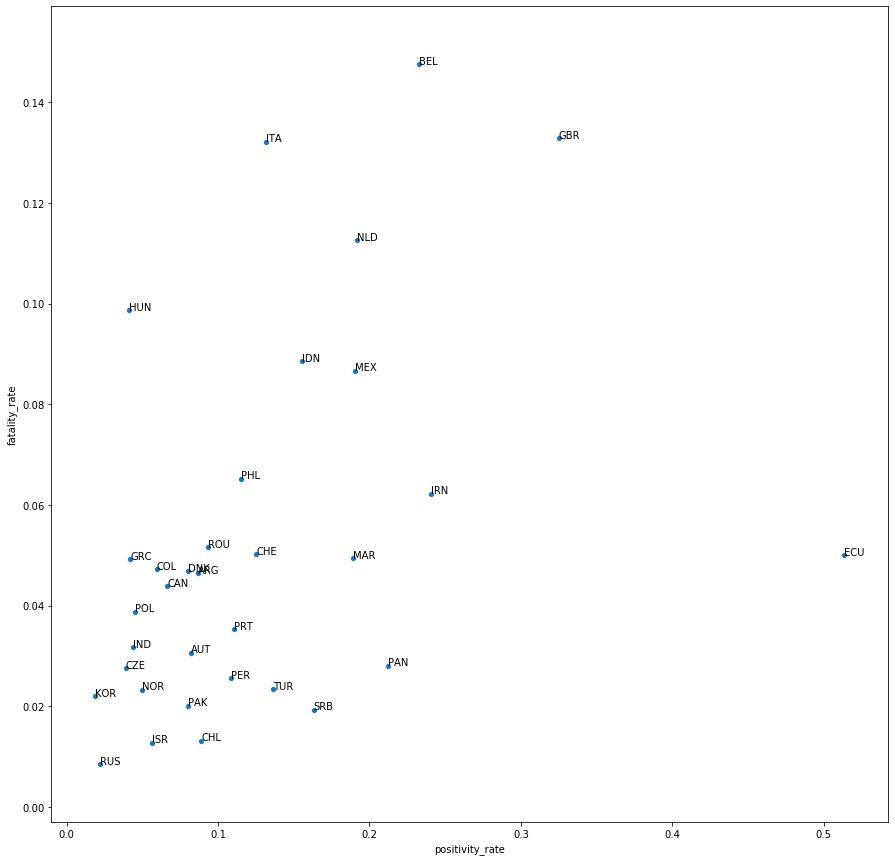

In [345]:
## rename label
DFZ.rename({'positivity_Rate':"positivity_rate","death_rate":"fatality_rate"},axis=1,inplace=True)

fig,axs=plt.subplots(figsize=(15,15))
sns.scatterplot(x='positivity_rate',y='fatality_rate',data=DFZ,ax=axs)

for label,posy,posx in zip(DFZ['ISO3'],DFZ["fatality_rate"],DFZ['positivity_rate']):
    axs.text(posx,posy,label)

we decide to drop ecuador

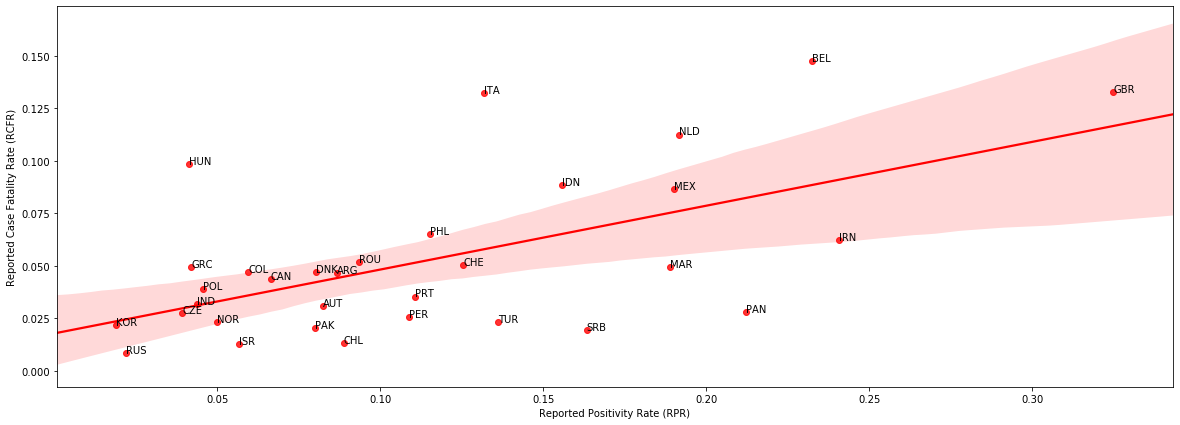

In [384]:
fig,axs=plt.subplots(figsize=(20,7))


DFZ=DFZ.loc[DFZ['ISO3']!="ECU",:].copy()

sns.regplot(x='positivity_rate',y='fatality_rate',data=DFZ,ax=axs,color="red")

for label,posy,posx in zip(DFZ['ISO3'],DFZ["fatality_rate"],DFZ['positivity_rate']):
    axs.text(posx,posy,label)

axs.set_xlabel("Reported Positivity Rate (RPR)")
axs.set_ylabel("Reported Case Fatality Rate (RCFR)");


In [347]:
results=smf.ols('fatality_rate  ~ +positivity_rate ',data=DFZ).fit(cov_type='HC2')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fatality_rate   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     14.67
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           0.000607
Time:                        12:23:41   Log-Likelihood:                 67.162
No. Observations:                  32   AIC:                            -130.3
Df Residuals:                      30   BIC:                            -127.4
Df Model:                           1                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0178      0.008      2.109      0.035       0.001       0.034
positivity_rate     0.3044      0.079      3.831      0.000       0.149       0.460
==============================================================================
Omnibus:                        4.146   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                2.793
Skew:                           0.687   Prob(JB):                        0.247
Kurtosis:                       3.454   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

residuals differences